In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core


!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'detectron2' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.12 ; cuda:  cu113
detectron2: 0.6


In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
cfg = get_cfg()
model = "COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(model))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model)
predictor = DefaultPredictor(cfg)

In [ ]:
def get_mappings():
  mappings = {}
  mappings[1] = 59
  mappings[7] = 57
  mappings[8] = 62
  mappings[10] = 75
  return mappings

In [ ]:
import json

with open('/content/drive/MyDrive/Segmentation/ann/annotations/instances_default.json', 'r') as f:
    data = f.read()

ann = json.loads(data)
categories = ann["categories"]
images = ann["images"]
annotations = ann["annotations"]

cat_images_data = {}
img_data = {}

for img in images:
  img_data[img["id"]] = img["file_name"]

for ann_data in annotations:
  cat_id = ann_data["category_id"]
  img_id = ann_data["image_id"]
  if cat_id not in cat_images_data:
    cat_images_data[cat_id] = []
  cat_images_data[cat_id].append(img_data[img_id])

print(categories)

[{'id': 1, 'name': 'Bed', 'supercategory': ''}, {'id': 2, 'name': 'Cabinet', 'supercategory': ''}, {'id': 3, 'name': 'Carpets', 'supercategory': ''}, {'id': 4, 'name': 'Floor', 'supercategory': ''}, {'id': 5, 'name': 'Generator', 'supercategory': ''}, {'id': 6, 'name': 'Room heaters', 'supercategory': ''}, {'id': 7, 'name': 'Sofa', 'supercategory': ''}, {'id': 8, 'name': 'Television', 'supercategory': ''}, {'id': 9, 'name': 'Treadmill', 'supercategory': ''}, {'id': 10, 'name': 'Vase', 'supercategory': ''}]


In [ ]:
# for cat in [10]:
#   count = 0
#   print('Cat: ', cat)
#   for img_file_name in cat_images_data[cat]:
#     print(img_file_name)
#     im = cv2.imread("/content/drive/MyDrive/Segmentation/ann/images/" + str(img_file_name))
#     outputs = predictor(im)
#     v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
#     out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#     cv2_imshow(out.get_image()[:, :, ::-1])
#     print(outputs["instances"].pred_classes)
#     print(outputs["instances"].pred_boxes)
#     count += 1
#     if count > 10:
#       break

In [ ]:
correct = 0
total = 0
for cat in cat_images_data:
  print('Running for category: ', cat)
  for img_file_name in cat_images_data[cat]:
    im = cv2.imread("/content/drive/MyDrive/Segmentation/ann/images/" + str(img_file_name))
    outputs = predictor(im)
    # v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    # out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # cv2_imshow(out.get_image()[:, :, ::-1])
    if cat in get_mappings() and get_mappings()[cat] in outputs["instances"].pred_classes:
      correct += 1
    total += 1

Running for category:  6
Running for category:  10
Running for category:  4
Running for category:  7
Running for category:  3
Running for category:  9
Running for category:  8
Running for category:  2
Running for category:  1
Running for category:  5


In [ ]:
print('Accuracy: ', (correct*100)/total)

Accuracy:  35.476190476190474


victoria-black-vase.jpg


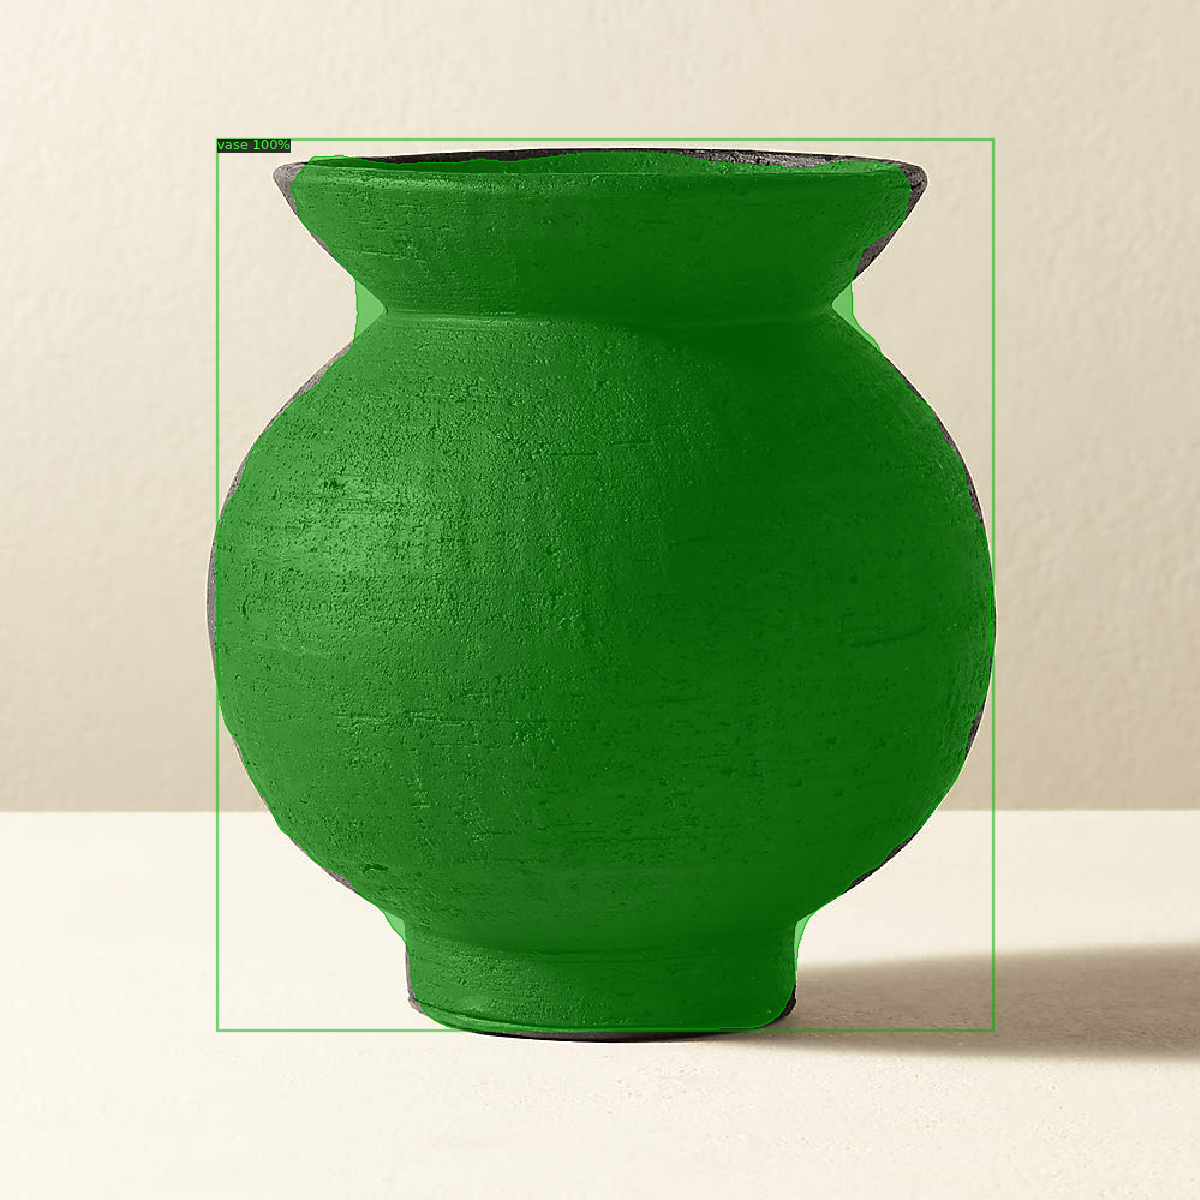

viljestark-vase-clear-glass__0640433_pe699813_s5.jpg


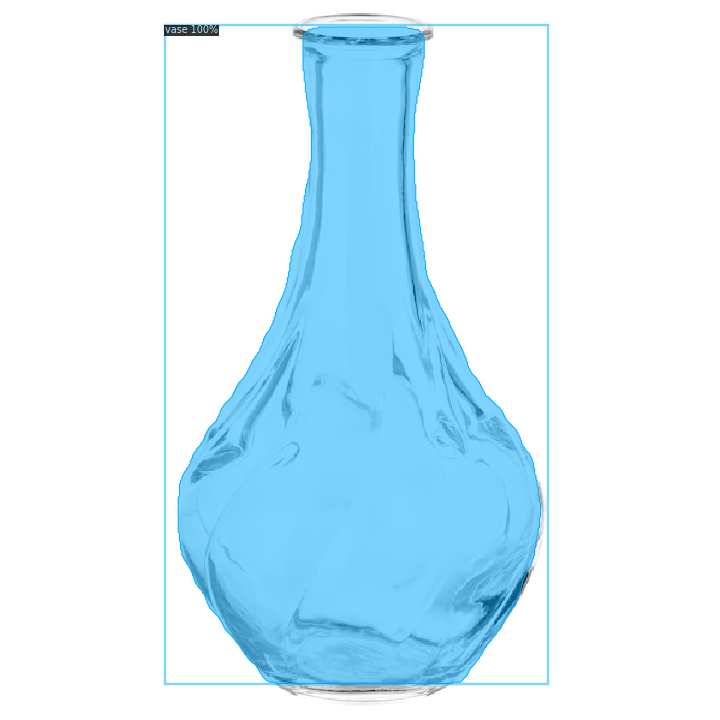

vinliden-sofa-hakebo-beige__0852744_pe780233_s5.jpg


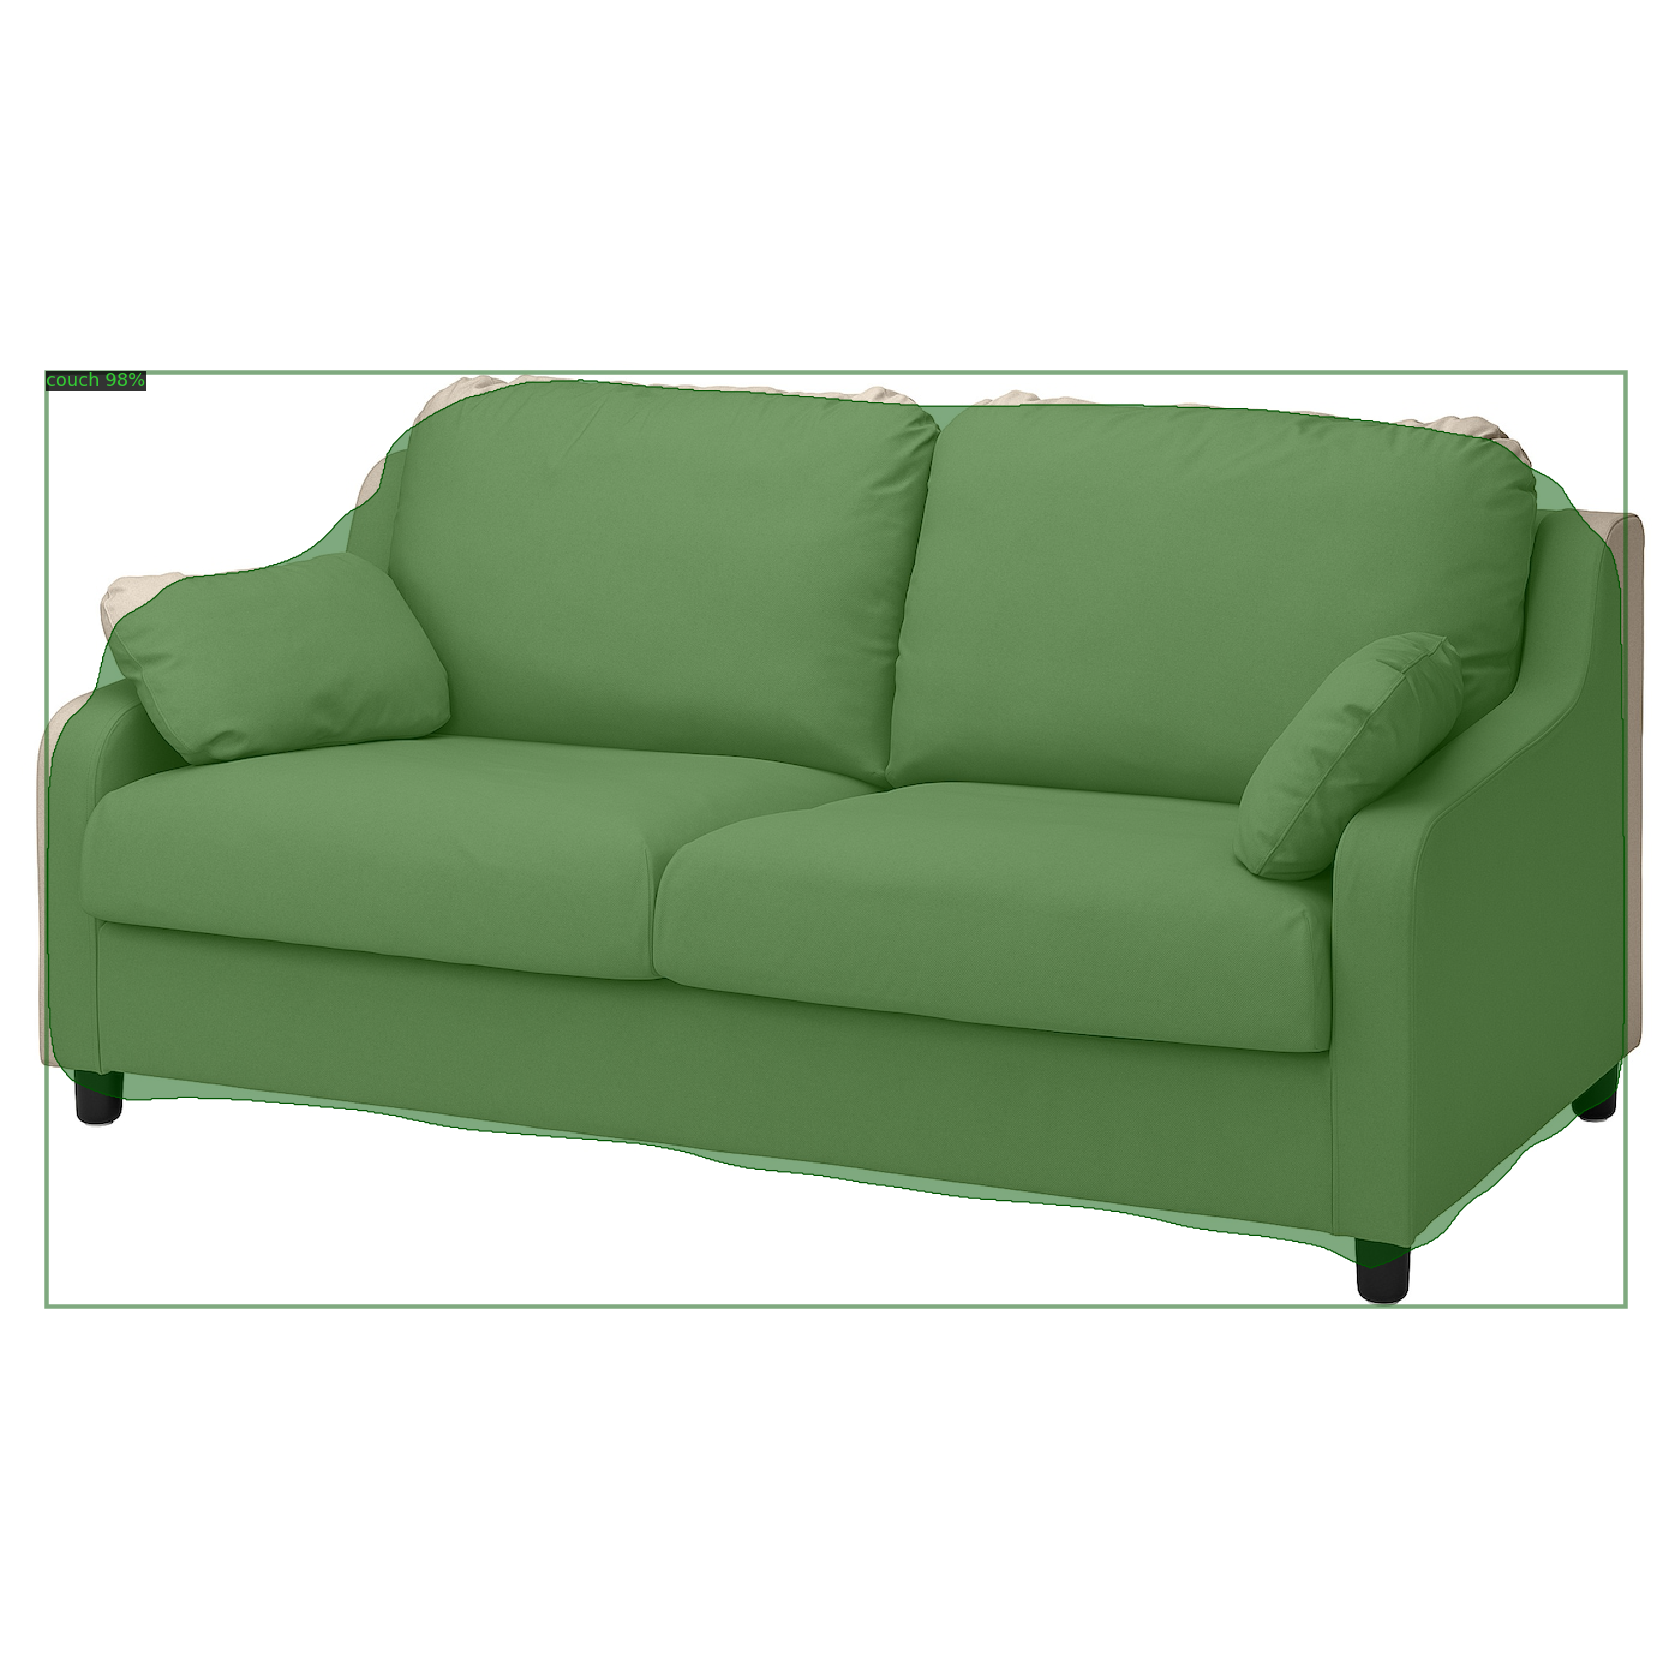

vintage-tv_23-2147503075.jpg


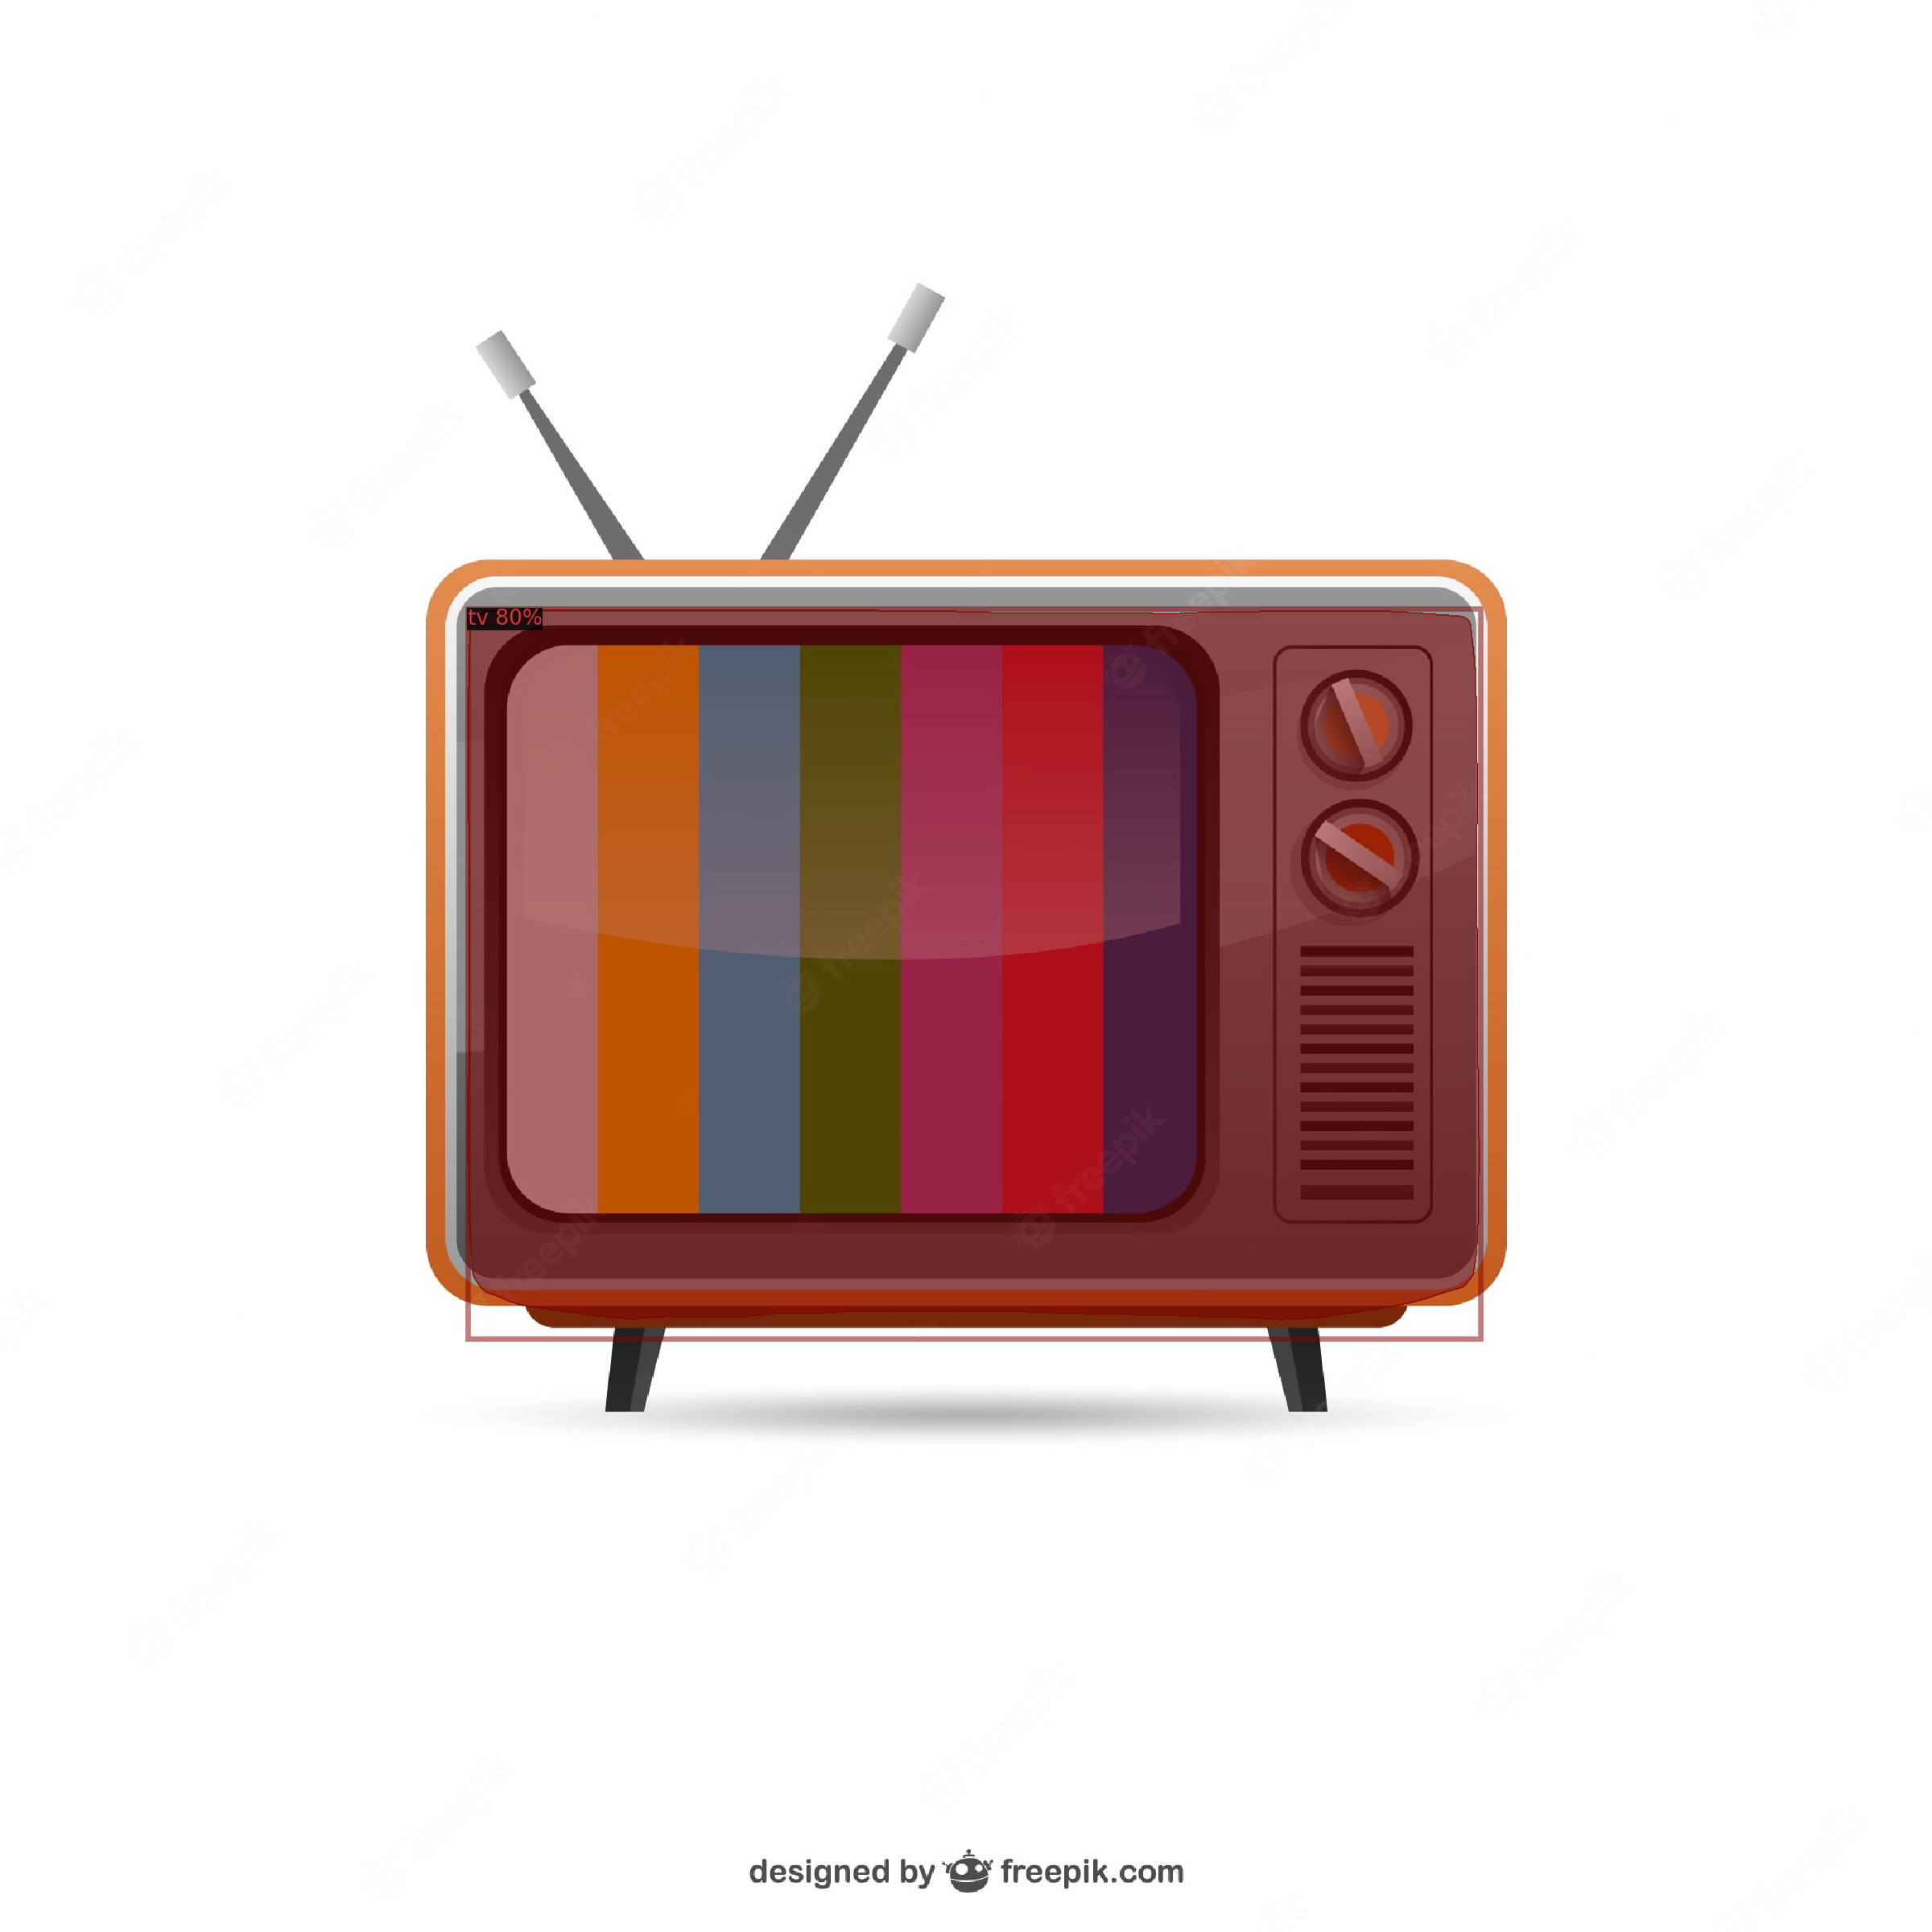

In [ ]:
# Visual output

DIR_PATH = '/content/drive/MyDrive/Segmentation/ann/images/'
directory = os.fsencode(DIR_PATH)

selected_files = ['victoria-black-vase.jpg', 'viljestark-vase-clear-glass__0640433_pe699813_s5.jpg', 'vinliden-sofa-hakebo-beige__0852744_pe780233_s5.jpg', 'vintage-tv_23-2147503075.jpg']
cnt = 0
for file in selected_files:
  file_name = os.fsdecode(file)
  print(file_name)
  im = cv2.imread(DIR_PATH + file_name)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])
  if cnt > 10:
    break;
  cnt += 1